# Exploring and Cleaning the Data

**Goals:** Discard unusable features, understand remaining features,
split the data into train and test sets.

**Summary:** The primary purpose of this notebook is to understand the 
LendingClub load dataset, and to prepare it for exploratory data 
analysis. We begin by loading the raw LendingClub loan dataset into 
a pandas dataframe. We summarize below our findings and the actions 
taken to achieve the stated goals.

1.  **Discard unusable features**: Features that are unavailable to 
the potential investor at the time of investment are identified and
dropped. In addition, we drop features that have only one unique value; 
such features, of course, add no value. We also drop features that 
are missing more than 30% of the values; in general it is difficult to 
accurately impute values for such features. 


2.  **Understand the numerical features:** After discarding unusable 
features, we are left with 15 numerical features. We study each of these
features carefully, plotting their histograms, and taking a look at 
various statistics. We observe that the features have very different 
scales, and some features have tail-heavy histograms, that is,
they extend much farther to the right of the median than to the left.
Since the presence of different scales and tail-heavy histograms 
may make some machine learning algorithms perform poorly, 
we will consider remedies later.


3.  **Understand the categorical features:** After discarding unusable 
features, we are left with 16 categorical features. We study each of 
these features carefully, making their count plots, and taking a
look at some statistics. We identify the ordinal and nominal features,
which will be processed later using an ordinal encoder and a 
one-hot encoder, respectively.


4.  **Split the data into training and test sets:** In order to avoid 
data snooping bias, we put aside a test set, which we will not use until
it is time to evaluate our final machine learning model.

In [1]:
# Load required packages and modules.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec
import seaborn as sns
from math import ceil, floor, log
import plotly.graph_objects as go
from matplotlib.ticker import PercentFormatter
from warnings import simplefilter
from sklearn.model_selection import train_test_split

# Suppress performance and data type warnings.
simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# Set the backend of matplotlib to 'inline'.
%matplotlib inline

# Create plots using seaborn's default aesthetic arguments. 
sns.set()

# Make this notebook's output identical across runs.
np.random.seed(1)

In [2]:
# Read the data into a pandas dataframe.
loan_data = pd.read_csv(
    'data/accepted_lending_club_loan_data_2007_to_2018Q4.csv.gz', 
    compression='gzip',
    low_memory=False)

Let's take a look at first five rows of the dataset, chosen randomly:

In [3]:
loan_data.sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
1557444,132555889,NaN,11000.0,11000.0,11000.0,36 months,10.90,359.61,B,B4,...,NaN,NaN,DirectPay,N,NaN,NaN,NaN,NaN,NaN,NaN
1089926,69743499,NaN,12000.0,12000.0,12000.0,36 months,6.99,370.48,A,A3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
71683,63590274,NaN,5000.0,5000.0,5000.0,36 months,12.05,166.20,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
356146,42364040,NaN,20000.0,20000.0,19975.0,36 months,15.61,699.30,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1396198,144254317,NaN,5000.0,5000.0,5000.0,36 months,18.94,183.13,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


Each row represents one loan. We see that there at 151 features. Let's get
additional information about the dataset:

In [4]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


We see that there are approximately 2.2 million rows, taking up 2.5 GB of 
memory. Of the 151 features, 113 are numerical, and 38 are non-numerical.

The descriptions of the features are available in the LendingClub *Data 
Dictionary* excel file found 
[here](https://resources.lendingclub.com/LCDataDictionary.xlsx).
Our main goal is to predict the probability of a charge off, and using 
the dictionary we determine that the target feature is **'loan_status'**, 
whose value counts are:

In [5]:
loan_data['loan_status'].value_counts(dropna=False)

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
NaN                                                         33
Name: loan_status, dtype: int64

We will consider only those rows with **loan_status** either 'Fully Paid' or 'Charged Off':

In [6]:
mask_loan_status = loan_data['loan_status'].isin(['Fully Paid', 
                                                  'Charged Off'])
loan_data = loan_data[mask_loan_status]

Let's take a look at the proportion of loans that are classified as 
'Fully Paid' and 'Charged Off':

In [7]:
loan_data['loan_status'].value_counts(normalize=True)

Fully Paid     0.800374
Charged Off    0.199626
Name: loan_status, dtype: float64

We see that the classes are imbalanced; we will keep this in mind 
when it's time to choose an evaluation metric for our machine learning
models.

As we've seen above, the raw dataset has 151 features. A quick glance
at the Data Dictionary tells us that we can safely drop several features
for various reasons, explained below. 

## 1. Discard Unusable Features

We begin by dropping features that have only one unique value:

In [8]:
cols_with_one_unique_val = [col for col in loan_data.columns 
                            if loan_data[col].nunique()==1]
loan_data.drop(columns=cols_with_one_unique_val, inplace=True)

In [9]:
n_rows, n_cols = loan_data.shape
print(f'Size of the dataset: {n_rows} rows and {n_cols} columns')

Size of the dataset: 1345310 rows and 143 columns


Let's take a look at the histogram of the feature-wise percentage of 
missing values:

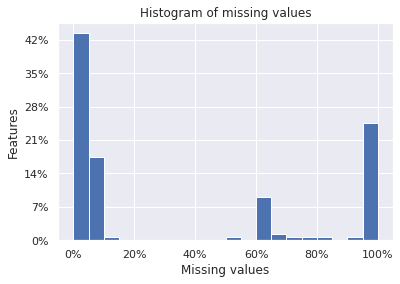

In [10]:
missing_vals_proportion = loan_data.isnull().mean()
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
missing_vals_proportion.hist(bins=20, ax=ax)
ax.set_title('Histogram of missing values')
ax.set_xlabel('Missing values')
ax.set_ylabel('Features')
xmax = len(loan_data.columns)
ax.xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
ax.yaxis.set_major_formatter(PercentFormatter(xmax=xmax, decimals=0))

We will drop the features that are missing more than 30% of the values:

In [11]:
na_thresh = 0.5
loan_data.dropna(how='any', axis='columns', 
                 thresh=(1-na_thresh)*n_rows, inplace=True)

In [12]:
n_rows, n_cols = loan_data.shape
print(f'Size of the dataset: {n_rows} rows and {n_cols} columns')

Size of the dataset: 1345310 rows and 88 columns


Next, we take a closer look at the Data Dictionary, to determine relevant 
features. 

In [13]:
# Read the Data Dictionary into a pandas dataframe.
data_dictionary = pd.read_excel('data/LCDataDictionary_2018.xlsx', 
                                index_col=0,
                                nrows=151)

# Ensure that all rows and columns are displayed, and that the columns are 
# not truncated.
pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None

# Display descriptions of the 88 features that still remain in the dataset.
data_dictionary.loc[loan_data.columns.to_list()].sort_index()

,Description
LoanStatNew,
acc_now_delinq,The number of accounts on which the borrower is now delinquent.
acc_open_past_24mths,Number of trades opened in past 24 months.
addr_state,The state provided by the borrower in the loan application
annual_inc,The self-reported annual income provided by the borrower during registration.
application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
avg_cur_bal,Average current balance of all accounts
bc_open_to_buy,Total open to buy on revolving bankcards.
bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.
chargeoff_within_12_mths,Number of charge-offs within 12 months


We will drop features that are unavailable to the potential investor at 
the time of investment, such as **last_pymnt_amnt** and **recoveries**.
We note one exception: even though the feature **issue_d** is unavailable 
at the time of investment, we keep it for now because we will consider 
using it to approximate the age of the borrower's oldest credit account. 
Additionally, we will also drop unusable features such as 
**id** and **url**. Before we drop the feature **id**, let's check if
it is a unique identifier for the rows of the data:

In [14]:
n_rows, _ = loan_data.shape
n_ids = loan_data['id'].nunique()
print('Number of rows:', n_rows)
print('Number of unique ids:', n_rows)

Number of rows: 1345310
Number of unique ids: 1345310


In [15]:
cols_to_drop = [
    'acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 
    'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 
    'collection_recovery_fee', 'collections_12_mths_ex_med', 
    'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 
    'disbursement_method', 'funded_amnt', 'funded_amnt_inv', 'id', 
    'inq_last_6mths', 'last_credit_pull_d', 'last_fico_range_high',
    'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d',
    'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op',
    'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq',
    'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
    'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 
    'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 
    'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 
    'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'recoveries', 'tot_coll_amt', 
    'tot_cur_bal', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
    'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv',
    'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 
    'total_rev_hi_lim', 'url']

# Drop columns identified above.
loan_data.drop(columns=cols_to_drop, inplace=True)

In [16]:
n_rows, n_cols = loan_data.shape
print(f'Size of the dataset: {n_rows} rows and {n_cols} columns')

Size of the dataset: 1345310 rows and 31 columns


Are there any rows with all entries null?

In [17]:
loan_data.isnull().all(axis='columns').sum()

0

Are there any duplicate rows?

In [18]:
loan_data.duplicated().sum()

0

Let's take a look at the features that remain:

In [19]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1345310 entries, 0 to 2260697
Data columns (total 31 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   loan_amnt             1345310 non-null  float64
 1   term                  1345310 non-null  object 
 2   int_rate              1345310 non-null  float64
 3   installment           1345310 non-null  float64
 4   grade                 1345310 non-null  object 
 5   sub_grade             1345310 non-null  object 
 6   emp_title             1259525 non-null  object 
 7   emp_length            1266799 non-null  object 
 8   home_ownership        1345310 non-null  object 
 9   annual_inc            1345310 non-null  float64
 10  verification_status   1345310 non-null  object 
 11  issue_d               1345310 non-null  object 
 12  loan_status           1345310 non-null  object 
 13  purpose               1345310 non-null  object 
 14  title                 1328651 non-

We see that that there are 15 numerical features and 16 categorical 
features remaining. In what follows, we will consider each of the features.
We begin with the numerical features.

## 2. Understand the Numerical Features

Let's take a look at the description of each numerical feature:

In [20]:
num_features = sorted(loan_data.columns[loan_data.dtypes 
                                        == 'float64'].to_list())
data_dictionary.loc[num_features]

,Description
LoanStatNew,
annual_inc,The self-reported annual income provided by the borrower during registration.
dti,"A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."
fico_range_high,The upper boundary range the borrower’s FICO at loan origination belongs to.
fico_range_low,The lower boundary range the borrower’s FICO at loan origination belongs to.
installment,The monthly payment owed by the borrower if the loan originates.
int_rate,Interest Rate on the loan
loan_amnt,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."
mort_acc,Number of mortgage accounts.
open_acc,The number of open credit lines in the borrower's credit file.


Let's gather some statistics for each numerical feature:

In [21]:
# Round to two decimal places in pandas. 
pd.options.display.float_format = '{:.2f}'.format

loan_data.describe(percentiles=[0.5, 0.99]).sort_index(axis='columns')

,annual_inc,dti,fico_range_high,fico_range_low,installment,int_rate,loan_amnt,mort_acc,open_acc,pub_rec,pub_rec_bankruptcies,revol_bal,revol_util,tax_liens,total_acc
count,1345310.00,1344936.00,1345310.00,1345310.00,1345310.00,1345310.00,1345310.00,1298029.00,1345310.00,1345310.00,1344613.00,1345310.00,1344453.00,1345271.00,1345310.00
mean,76247.64,18.28,700.19,696.19,438.08,13.24,14419.97,1.67,11.59,0.22,0.13,16248.11,51.81,0.05,24.98
std,69925.10,11.16,31.85,31.85,261.51,4.77,8717.05,2.00,5.47,0.60,0.38,22328.17,24.52,0.40,12.00
min,0.00,-1.00,629.00,625.00,4.93,5.31,500.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00
50%,65000.00,17.61,694.00,690.00,375.43,12.74,12000.00,1.00,11.00,0.00,0.00,11134.00,52.20,0.00,23.00
99%,250000.00,38.47,804.00,800.00,1221.50,26.30,35000.00,8.00,29.00,2.00,1.00,94553.91,98.20,2.00,61.00
max,10999200.00,999.00,850.00,845.00,1719.83,30.99,40000.00,51.00,90.00,86.00,12.00,2904836.00,892.30,85.00,176.00


Some rows have negative **dti** (percentage of monthly debt payment to 
monthly income). How many such rows are there?

In [22]:
mask_dti = loan_data['dti'] < 0
print('Number of rows with negative dti:', mask_dti.sum())

Number of rows with negative dti: 2


Some rows have **dti** greater than 100. How many such rows are there?

In [23]:
vals = [100, 400, 800]
print('Number of rows with dti greater than')
for val in vals:
    mask_dti = loan_data['dti'] > val
    print(f'{val}:', mask_dti.sum())

Number of rows with dti greater than
100: 533
400: 85
800: 44


In some rows, the value of the feature **revol_util** (percentage of total 
revolving credit balance to total available revolving credit) is greater than 
100. How many such rows are there?

In [24]:
vals = [100, 150, 200]
print('Number of rows with revol_util greater than')
for val in vals:
    mask_revol_util = loan_data['revol_util'] > val
    print(f'{val}:', mask_revol_util.sum())

Number of rows with revol_util greater than
100: 4687
150: 20
200: 2


Next, we wish to take a look at the histogram of each numerical feature. 
We observe that several features include extreme outliers, which will make 
the histograms ineffective if we don't handle these outliers appropriately.
As such, we will first manually choose bin edges and clip points for the 
data before plotting the histograms.

In [25]:
# In a histogram plot that uses numpy.histogram_bin_edges, the bar to the 
# furthest right includes the right edge, unlike the other bars; we choose
# 'a_max' accordingly.
bin_edges_and_clips = {
    'annual_inc': {'bin_edges': np.arange(0, 300001, 5000), 'a_max': 300000},
    'dti': {'bin_edges': np.arange(0, 41, 1), 'a_max': 40},
    'mort_acc': {'bin_edges': np.arange(0, 11, 1), 'a_max': 10},             
    'open_acc': {'bin_edges': np.arange(0, 31, 1), 'a_max': 30},
    'pub_rec': {'bin_edges': np.arange(0, 5, 1), 'a_max': 3},
    'pub_rec_bankruptcies': {'bin_edges': np.arange(0, 4, 1), 'a_max': 2}, 
    'revol_bal': {'bin_edges': np.arange(0, 100001, 2000), 'a_max': 100000},
    'revol_util': {'bin_edges': np.arange(0, 101, 2), 'a_max': 100},
    'tax_liens': {'bin_edges': np.arange(0, 5, 1), 'a_max': 3},
    'total_acc': {'bin_edges': np.arange(0, 81, 2), 'a_max': 80}                 
}

# http://stackoverflow.com/questions/579310
def human_readable(num):
    ''' Convert given number to human-readable form. ''' 
    num = float('{:.3g}'.format(num))
    magnitude = int(floor(log(abs(num), 1000))) if abs(num) >= 1000 else 0
    num = num / 1000**magnitude
    units = ['', 'K', 'M', 'B', 'T', 'Q']
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), 
                         units[magnitude])

Now that bin edges and clip points have been chosen, let's plot the 
histograms:

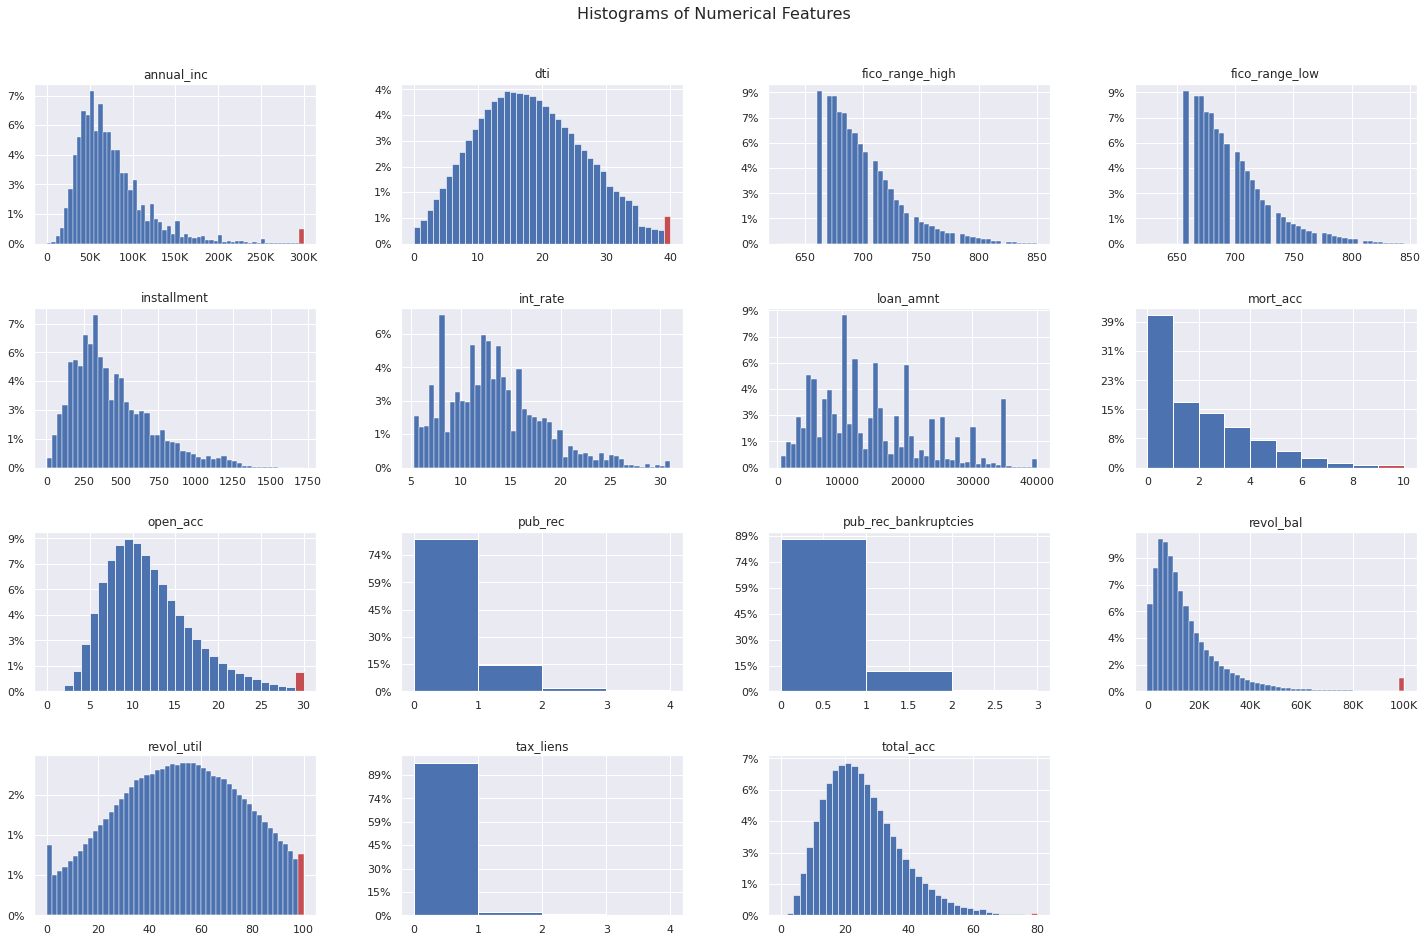

In [26]:
n_cols = 4
n_rows = ceil(len(num_features)/n_cols)
aspect = 1.5
fig = plt.figure(figsize=(20, (n_rows/n_cols)*(20/aspect)))
fig.suptitle('Histograms of Numerical Features', fontsize=16)

for counter, feature in enumerate(num_features, 1):
    ax = fig.add_subplot(n_rows, n_cols, counter)
    if feature in bin_edges_and_clips:
        bin_edges = bin_edges_and_clips[feature]['bin_edges']
        a_max = bin_edges_and_clips[feature]['a_max']
        x = np.clip(loan_data[feature], a_min=None, a_max=a_max) 
        sns.histplot(bins=bin_edges, x=x, stat='count', alpha=1, ax=ax)
        ax.patches[-1].set_facecolor('r')
        fig.canvas.draw()
        labels = [item.get_text() for item in ax.get_xticklabels()]
        labels = [float(item.replace('\u2212', '-')) for item in labels]
        labels = [human_readable(item) for item in labels]
        ax.set_xticklabels(labels)
    else:
        bins = 50
        x = loan_data[feature]    
        sns.histplot(bins=bins, x=x, stat='count', alpha=1, ax=ax)
    ax.set_title(feature)  
    ax.set_xlabel('')
    ax.set_ylabel('')  
    xmax = loan_data[feature].notnull().sum()
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=xmax, decimals=0))

fig.tight_layout()
fig.subplots_adjust(top=0.90, wspace=0.3, hspace=0.4)  

Each red-colored bar above includes all values greater than or equal to the 
left edge of the bar.

Based on the information gathered so far, we make observations about each
numerical feature:

* **annual_inc** (annual income): 99% of the values are between $0 and 
$250,000. The median is $65,000, and the maximum is approximately 
$11 million. 


* **dti** (percentage of monthly debt payment to monthly income): 99% of 
the values are between -1 and 38. The median is 18, and the maximum 
is 999. There are two rows that have a negative value. We suspect this 
is a data entry error, and as such we will drop the two rows.  


* **fico_range_low, fico_range_high** (lower and upper boundary of 
borrower's FICO score range): The histograms of these two features have
identical shape. We will consider combining these features 
after further investigation.


* **installment** (monthly payment owed on the loan): The values range
from approximately $5 to $1720, with median $375.


* **int_rate** (interest rate on the loan): The values range from 5.31%
to 30.99%, with median 12.74%.


* **loan_amnt** (loan amount): The values range from $500 to $40,000,
with median $12,000.


* **mort_acc** (number of mortgage accounts): 99% of the values are
between 0 and 8. The median is 1, and the maximum is 51.


* **open_acc** (number of open credit lines): 99% of the values are
between 0 and 29. The median is 11, and the maximum is 90.


* **pub_rec** (number of derogatory public records): 99% of the values are
either 0, 1, or 2. The median is 0, and the maximum is 86.


* **pub_rec_bankruptcies** (number of public record bankruptcies): 99% of 
the values are either 0 or 1. The median is 0, and the maximum is 12. 


* **revol_bal** (total revolving credit balance): 99% of the values are 
between $0 and $95,000. The median is $11,000, and the maximum is 
approximately $3 million. 


* **revol_util** (percentage of **revol_bal** to total available 
revolving credit): 99% of the values are between 0 and 98. 
The median is 52, and the maximum is 892. How is a value greater than 100
possible? The *Credit Card Accountability, Responsibility and Disclosure Act*
made it difficult for borrowers to go over their credit limit,
but it is still possible, as can be seen from this 
[information](https://www.consumerfinance.gov/ask-cfpb/i-went-over-my-credit-limit-and-i-was-charged-an-overlimit-fee-what-can-i-do-en-58/) 
provided by the *Consumer Financial Protection Bureau*. There are two rows 
that have values in excess of 200. We suspect this is a data entry error, 
and as such we will drop the two rows.  


* **tax_liens** (number of tax liens): 99% of the values are
either 0, 1, or 2. The median is 0, and the maximum is 85.


* **total_acc** (number of credit lines): 99% of the values are
between 0 to 61. The median is 23, and the maximum is 176.


The features **annual_inc**, **dti**, and **revol_bal** have tail-heavy 
histograms, that is, they extend much farther to the right of the median 
than to the left. Since this may make it hard for some machine learning 
algorithms to detect patterns, we will consider transforming these 
features to have a more bell-shaped distribution.

The features have very different scales. Since this may make some machine 
learning algorithms perform poorly, we will consider scaling the features.

In [27]:
# Drop rows that have negative dti values.
mask_dti = loan_data['dti'] < 0
loan_data = loan_data[~mask_dti]

In [28]:
n_rows, n_cols = loan_data.shape
print(f'Size of the dataset: {n_rows} rows and {n_cols} columns')

Size of the dataset: 1345308 rows and 31 columns


In [29]:
# Drop rows that have revol_util values greater than 200.
mask_revol_util = loan_data['revol_util'] > 200
loan_data = loan_data[~mask_revol_util]

In [30]:
n_rows, n_cols = loan_data.shape
print(f'Size of the dataset: {n_rows} rows and {n_cols} columns')

Size of the dataset: 1345306 rows and 31 columns


## 3. Understand the Categorical Features

Let's take a look at the description of each categorical feature:

In [31]:
cat_features = sorted(loan_data.columns[loan_data.dtypes 
                                        == 'object'].to_list())
cat_features.remove('loan_status')
data_dictionary.loc[cat_features]

,Description
LoanStatNew,
addr_state,The state provided by the borrower in the loan application
application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
earliest_cr_line,The month the borrower's earliest reported credit line was opened
emp_length,Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
emp_title,The job title supplied by the Borrower when applying for the loan.*
grade,LC assigned loan grade
home_ownership,"The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER"
initial_list_status,"The initial listing status of the loan. Possible values are – W, F"
issue_d,The month which the loan was funded


In [32]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.max_colwidth') 

Let's gather some statistics for each categorical feature:

In [33]:
loan_data.describe(include=[object]).sort_index(axis='columns')

,addr_state,application_type,earliest_cr_line,emp_length,emp_title,grade,home_ownership,initial_list_status,issue_d,loan_status,purpose,sub_grade,term,title,verification_status,zip_code
count,1345306,1345306,1345306,1266795,1259521,1345306,1345306,1345306,1345306,1345306,1345306,1345306,1345306,1328647,1345306,1345305
unique,51,2,739,11,378353,7,6,2,139,2,14,35,2,61682,3,943
top,CA,Individual,Aug-2001,10+ years,Teacher,B,MORTGAGE,w,Mar-2016,Fully Paid,debt_consolidation,C1,36 months,Debt consolidation,Source Verified,945xx
freq,196527,1319507,9391,442197,21268,392739,665576,784008,48936,1076748,780317,85494,1020741,660956,521271,15005


Let's take a look at all the categories for each categorical feature,
except **earliest_cr_line**, **issue_d**, **title**, and **zip_code**, which
have 739, 378353, 139, 61682, and 943 categories, respectively:

In [34]:
# Categorical features that have too many categories.
cat_features_too_many = ['earliest_cr_line', 'emp_title', 'issue_d', 'title', 
                         'zip_code']
# Categorical features that have a reasonable number of categories.
cat_features_reasonable = [elm for elm in cat_features 
                           if elm not in cat_features_too_many]
for feature in cat_features_reasonable:
    print(f'{feature}:', sorted(loan_data[feature].unique().astype(str)), 
          '\n')

addr_state: ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'] 

application_type: ['Individual', 'Joint App'] 

emp_length: ['1 year', '10+ years', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '< 1 year', 'nan'] 

grade: ['A', 'B', 'C', 'D', 'E', 'F', 'G'] 

home_ownership: ['ANY', 'MORTGAGE', 'NONE', 'OTHER', 'OWN', 'RENT'] 

initial_list_status: ['f', 'w'] 

purpose: ['car', 'credit_card', 'debt_consolidation', 'educational', 'home_improvement', 'house', 'major_purchase', 'medical', 'moving', 'other', 'renewable_energy', 'small_business', 'vacation', 'wedding'] 

sub_grade: ['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D

Let's take a look at five random values for each of the features
**earliest_cr_line**, **emp_title**, **issue_d**, **title**, and **zip_code**:

In [35]:
for feature in cat_features_too_many:
    print(f'{feature}:', list(loan_data[feature].sample(5).values), '\n')

earliest_cr_line: ['Mar-2012', 'Jun-2006', 'May-2003', 'Mar-2002', 'Feb-1997'] 

emp_title: ['JEOL USA', 'RN', 'senior staff nurse', 'Account tech 2', 'Piping Shop Foreman // Safety Rep'] 

issue_d: ['Jun-2016', 'Feb-2018', 'Jul-2014', 'Jun-2017', 'Jul-2017'] 

title: ['Credit card refinancing', 'Debt consolidation', 'debt con', 'Home improvement', 'Credit card refinancing'] 

zip_code: ['958xx', '079xx', '275xx', '209xx', '331xx'] 



What are the 15 most frequent values for **emp_title** and **title**?

In [36]:
print(list(loan_data['emp_title'].value_counts(dropna=False).sort_values(ascending=False).head(15).index))

[nan, 'Teacher', 'Manager', 'Owner', 'Registered Nurse', 'RN', 'Supervisor', 'Driver', 'Sales', 'Project Manager', 'Office Manager', 'General Manager', 'Director', 'owner', 'manager']


In [37]:
print(list(loan_data['title'].value_counts(dropna=False).sort_values(ascending=False).head(15).index))

['Debt consolidation', 'Credit card refinancing', 'Home improvement', 'Other', 'Major purchase', nan, 'Debt Consolidation', 'Medical expenses', 'Business', 'Car financing', 'Vacation', 'Moving and relocation', 'Home buying', 'Consolidation', 'debt consolidation']


Let's make count plots of those categorical features that have a reasonable 
number of categories:

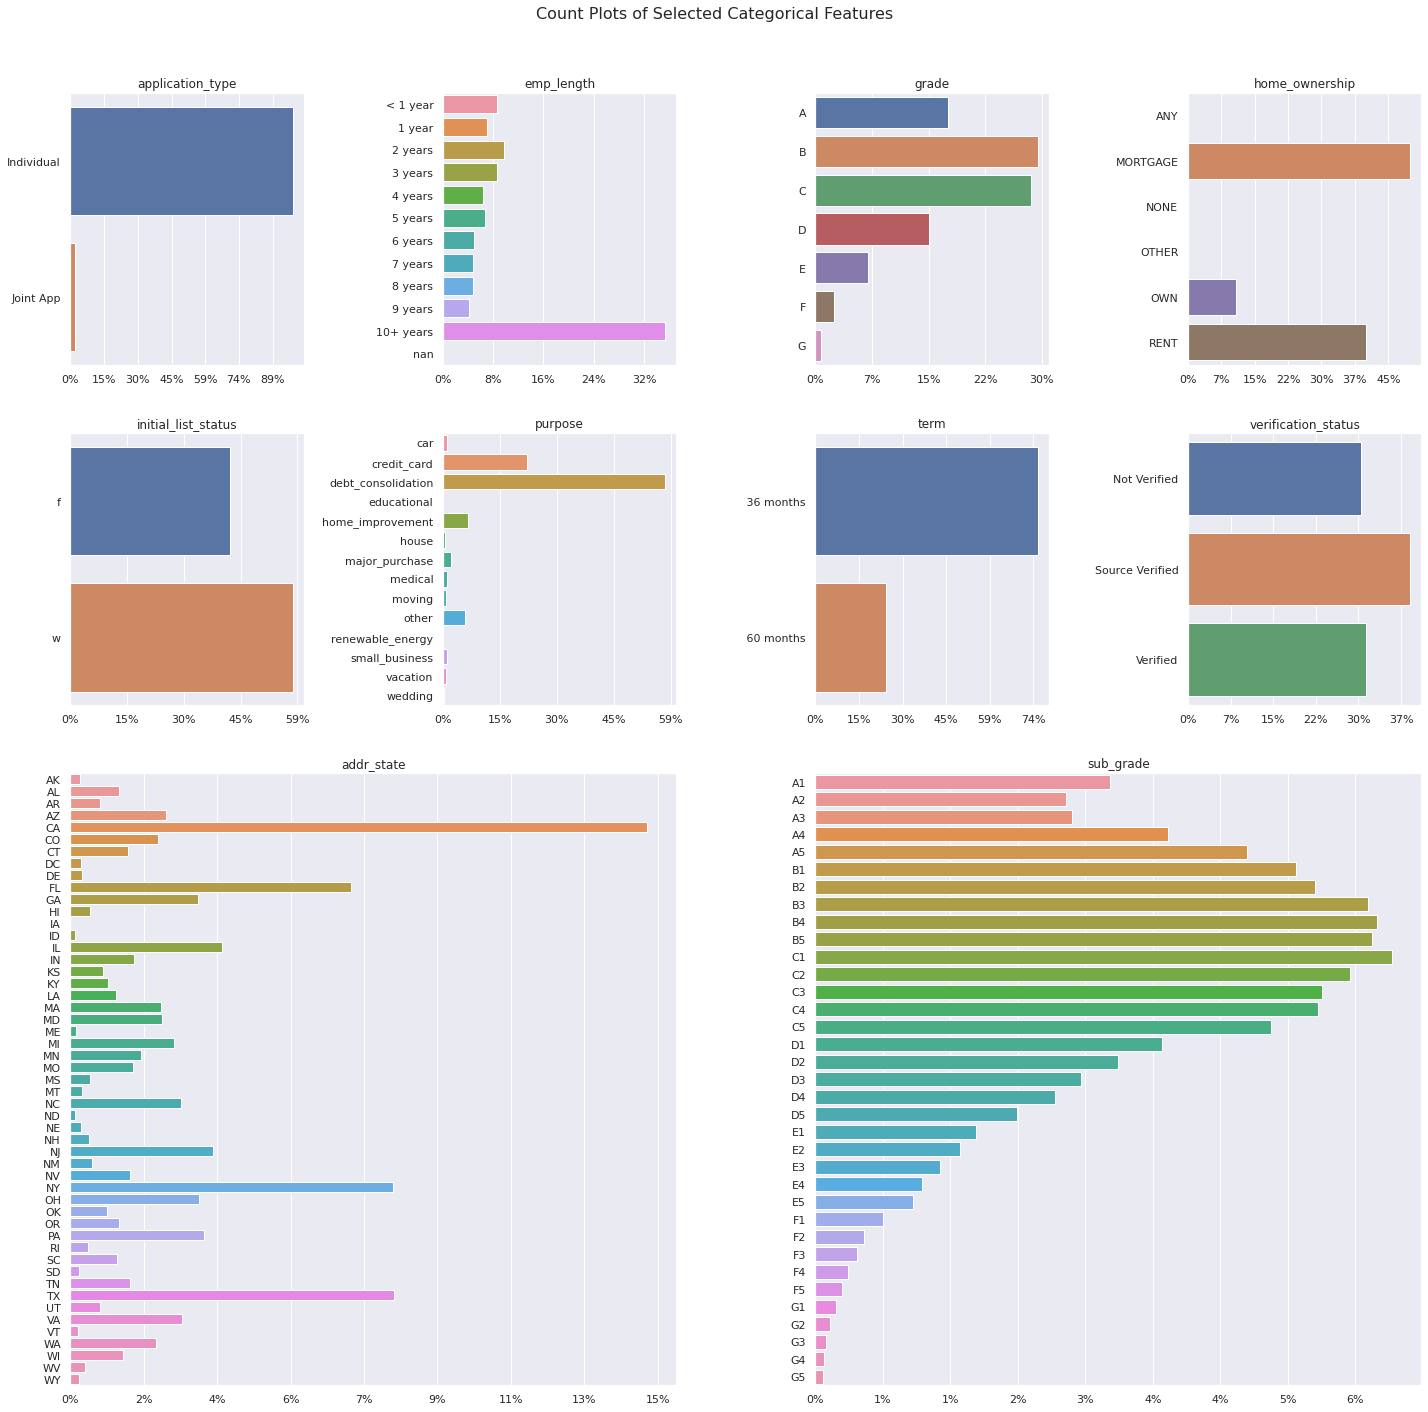

In [38]:
n_cols = 4
n_rows = 4
aspect = 1
fig = plt.figure(figsize=(20, (n_rows/n_cols)*(20/aspect)))
gs = fig.add_gridspec(n_rows, n_cols)
fig.suptitle('Count Plots of Selected Categorical Features', fontsize=16)

# Move the features 'addr_state' and 'sub_grade' to the end of the list.
cat_features_tmp = [elm for elm in cat_features_reasonable
                    if elm not in ['addr_state', 'sub_grade']]
cat_features_tmp.extend(['addr_state', 'sub_grade'])

for counter, feature in enumerate(cat_features_tmp, 0):
    if feature == 'addr_state':
        ax = fig.add_subplot(gs[2:4, 0:2])
    elif feature == 'sub_grade':
        ax = fig.add_subplot(gs[2:4, 2:4])
    else:
        ax = fig.add_subplot(gs[counter // n_cols, counter % n_cols])
    if feature == 'emp_length':
        order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', 
                 '5 years', '6 years', '7 years', '8 years', '9 years',  
                 '10+ years', 'nan']
    else:
        order = sorted(loan_data[feature].unique())
    sns.countplot(y=feature, data=loan_data, order=order, ax=ax)
    ax.set_title(feature) 
    ax.set_xlabel('')
    ax.set_ylabel('') 
    xmax = loan_data[feature].notnull().sum()
    ax.xaxis.set_major_formatter(PercentFormatter(xmax=xmax, decimals=0))

fig.tight_layout()  
fig.subplots_adjust(top=0.92, hspace=0.25)

We see from the count plot above that the top three states by number of
loans issued are California, Texas, and New York. Let's see what the
ranking is by total loan volume:

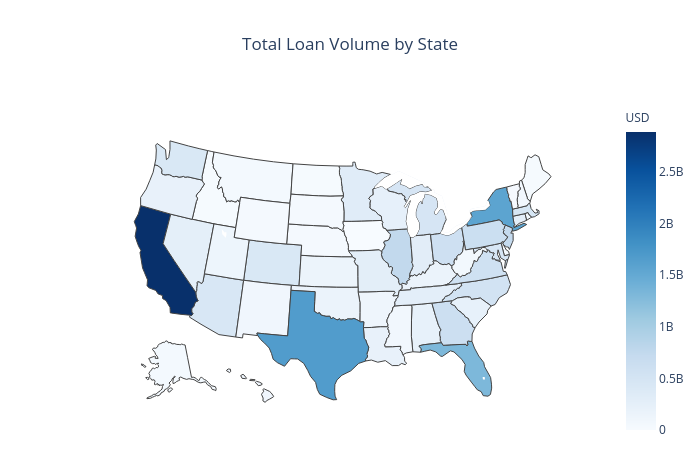

In [39]:
loan_amnt_by_state = loan_data.groupby('addr_state')['loan_amnt'].sum()

fig = go.Figure(data=go.Choropleth(
    locations=loan_amnt_by_state.index, z=loan_amnt_by_state, 
    locationmode='USA-states', colorscale='Blues', colorbar_title='USD'))

fig.update_layout(
    width=600, height=400, title_text = 'Total Loan Volume by State', 
    title_x=0.5, geo_scope='usa', margin=dict(b=10)
)

fig.update_yaxes(automargin=True)
# Ensure that the plot is shown on github.
fig.show('png')

Based on the information gathered so far, we make observations about each
categorical feature:

* **addr_state** (state): There are 51 categories, ranging from 'AK' to 'WY',
including 'DC' for Washington, DC. We will use one-hot encoding for this 
feature.


* **application_type** (individual application or a joint application):
There two categories, 'Individual' and 'Joint App', with more than 90%
of the instances belonging to the first category. We will use one-hot 
encoding for this feature.


* **earliest_cr_line**, **issue_d** (month and year of opening of borrower's 
earliest credit line, month and year in which the loan was funded):
We will consider combining these two features to approximate the age of the 
borrower's oldest credit account.


* **emp_length** (employment length in years): There are 12 categories,
ranging from '< 1 year' to '10+ years', and the null value. We will 
consider using ordinal encoding for this feature after further investigation.


* **emp_title** (job title): There are 378,353 categories. This feature
does not lend itself to ordinal encoding, and there are far too many categories
for one-hot encoding to be effective. Perhaps using just the top 10-15
categories may be useful, or perhaps applying natural language processing
techniques may effective, but to keep things simple, we will drop this feature.


* **grade**, **sub_grade** (loan grade, loan subgrade): The features **grade**
and **sub_grade** have 7 and 35 categories, ranging from 'A' to 'G',
and from 'A1' to 'G5', respectively. The value of the feature **sub_grade**
determines the value of the feature **grade**, and so we will drop the
feature **grade**. We will consider using ordinal encoding for the 
feature **sub_grade** after further investigation.


* **home_ownership** (home ownership status): There are 6 categories,
'ANY', 'MORTGAGE', 'NONE', 'OTHER', 'OWN', and 'RENT', with very few instances
belonging to the last three categories. We will replace the values 'ANY' and 
'NONE' with 'OTHER'. We will use one-hot encoding for this feature.


* **initial_list_status** (initial listing status of the loan): There are two
categories, 'f' and 'w'. While the Data Dictionary does not explain what
these codes mean, a Google 
[search](https://www.lendacademy.com/lending-club-whole-loan-program-one-year-later/) 
reveals that they denote 'Fractional' and 'Whole'. 
In the year 2012, LendingClub announced that it would begin setting aside some loans
that could only be purchased in their entirety ('w'). We will use one-hot encoding for 
this feature.


* **purpose** (purpose of loan): There are 14 categories, with about 60% of the 
instances belonging to the 'debt_consolidation' category. We will use one-hot 
encoding for this feature.


* **term** (loan duration in months): There are 2 categories, '36 months'
and '60 months', with about 75% of the instances belonging to the first
category. We will consider using ordinal encoding for this feature after 
further investigation.


* **title** (loan title): There are 61,682 categories. As was the case
with the feature **emp_title**, neither ordinal encoding nor one-hot encoding
is appropriate for this feature. Moreover, it appears that the feature **purpose** 
contains the information provided by this feature, and as such we will 
drop this feature.


* **verification_status** (income verified or not): There are three categories, 
'Not Verified', 'Source Verified', and 'Verified'. We will use one-hot 
encoding for this feature.


* **zip_code** (first three digits of zip code): There are 943 categories.
As was the case with the features **emp_title** and **title**, neither ordinal 
encoding nor one-hot encoding is appropriate for this feature. We will consider 
creating a new feature containing the median income of each 3-digit zip code.

In [40]:
# Drop the feature 'emp_title'.
loan_data.drop(columns=['emp_title'], inplace=True)

In [41]:
n_rows, n_cols = loan_data.shape
print(f'Size of the dataset: {n_rows} rows and {n_cols} columns')

Size of the dataset: 1345306 rows and 30 columns


In [42]:
# Drop the feature 'grade'.
loan_data.drop(columns=['grade'], inplace=True)

In [43]:
n_rows, n_cols = loan_data.shape
print(f'Size of the dataset: {n_rows} rows and {n_cols} columns')

Size of the dataset: 1345306 rows and 29 columns


In [44]:
# Replace the values 'ANY' and 'NONE' by 'OTHER' in the 
# feature 'home_ownership'.
loan_data['home_ownership'].replace(['ANY', 'NONE'], 'OTHER', inplace=True)

In [45]:
# Print all the categories of the feature 'home_ownership'
sorted(loan_data['home_ownership'].unique())

['MORTGAGE', 'OTHER', 'OWN', 'RENT']

In [46]:
# Drop the feature 'title'.
loan_data.drop(columns=['title'], inplace=True)

In [47]:
n_rows, n_cols = loan_data.shape
print(f'Size of the dataset: {n_rows} rows and {n_cols} columns')

Size of the dataset: 1345306 rows and 28 columns


## 4. Split the Data into Training and Test Sets

Before we set aside a test set, let's take a look at the number of missing 
values for each feature:

In [48]:
loan_data.isnull().sum().sort_index()

addr_state                  0
annual_inc                  0
application_type            0
dti                       374
earliest_cr_line            0
emp_length              78511
fico_range_high             0
fico_range_low              0
home_ownership              0
initial_list_status         0
installment                 0
int_rate                    0
issue_d                     0
loan_amnt                   0
loan_status                 0
mort_acc                47281
open_acc                    0
pub_rec                     0
pub_rec_bankruptcies      697
purpose                     0
revol_bal                   0
revol_util                857
sub_grade                   0
tax_liens                  39
term                        0
total_acc                   0
verification_status         0
zip_code                    1
dtype: int64

We will take care of the missing values later.

In order to avoid data snooping bias, we will now put aside a test set:

In [49]:
loan_data_train, loan_data_test = train_test_split(
    loan_data, test_size=0.2, stratify=loan_data['loan_status'])

Let's save the training and test sets:

In [50]:
loan_data_train.to_hdf('data/loan_data_train_and_test.hd5', 
                       key='train', mode='w')
loan_data_test.to_hdf('data/loan_data_train_and_test.hd5', 
                      key='test', mode='a')